# la Resting ECG de la clase dos es bernoulli! y la estamos tratando como multinomial

# Es mejor que cada una tenga su distribucion

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson

In [2]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [3]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [4]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [5]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

# sort df by class, later the Iwi[i] will be sorted by this order
df = df.sort_values(by=[df.columns[-1]])
df = df.reset_index(drop=True)

In [6]:
classes = df.iloc[:, -1].unique() # M
total = len(df)                   # N
attributes = df.columns           # X_i i \in {1, 2, ...}

Iwi = []        # Table of instances for each class
pwi = []        # a priori probability
pxjIwi = []     # p(X_j|w_i) for each class

In [7]:
for i in range(len(classes)):                   # For every class

    Iwi.append(df[df.iloc[:, -1] == classes[i]])         # Append the instances of the class
    pwi.append(len(Iwi[i])/total)               # Append the a priori probability
    
    pxjIwi.append([])                           # Append an empty list for the conditional probability - chat

In [8]:
for i in range(len(classes)):                   # For every class

    for attribute in attributes[:-1]:        # For every attribute except the last one (target variable)

        unique_values = Iwi[i][attribute].unique()

        # Poisson distribution
        if len(unique_values) < 10:
        # Test if the attribute is Poisson distributed
            mean = Iwi[i][attribute].mean()
            ks_test = kstest(Iwi[i][attribute], 'poisson', args=(mean,))    # - test if the attribute is Poisson distributed
            if ks_test.pvalue > 0.05:
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

        # Multinomial distribution

        # Normal distribution
        else: 
            shapiro_test = shapiro(Iwi[i][attribute])
            if shapiro_test.pvalue > 0.05:
                xbar = Iwi[i][attribute].mean()
                s = Iwi[i][attribute].std()
                un_pxiIwi = norm(xbar, s)             # Create a Normal distribution

        # KDE distribution
            else:
                un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability

        pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

In [9]:
def probability_categorical(attribute, value, Iwi):
    exitoIwi = len(Iwi[Iwi[attribute] == value])
    nIwi = len(Iwi)
    p = exitoIwi/nIwi
    return p

In [10]:
def diagnostic(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    Pwis = []

    for clase in range(len(classes)):

        # Tienen que ir adentro porque los de la clase 3 no tienen Chest Pain Type 1

        Page = pxjIwi[clase][0].pdf(age)
        Psex = probability_categorical("Sex", sex, Iwi[clase])
        Pcpt = probability_categorical("Chest Pain Type", chest_pain_type, Iwi[clase])
        Prbp = pxjIwi[clase][3].pdf(resting_blood_pressure)
        Pcho = pxjIwi[clase][4].pdf(cholesterol)
        Pfbs = probability_categorical("Fasting Blood Sugar", fasting_blood_sugar, Iwi[clase])
        Prec = probability_categorical("Resting ECG", resting_ecg, Iwi[clase])
        Pmhr = pxjIwi[clase][7].pdf(max_heart_rate)
        Peia = probability_categorical("Exercise Induced Angina", exercise_induced_angina, Iwi[clase])
        Pstd = pxjIwi[clase][9].pdf(st_depression)
        Pslo = probability_categorical("Slope", slope, Iwi[clase])
        Pnmv = probability_categorical("Number of Major Vessels", number_of_major_vessels, Iwi[clase])
        # Ptal = pxjIwi[clase][12].evaluate(thal)
        
        Pwi = pwi[clase] * Page * Psex * Pcpt * Prbp * Pcho * Pfbs * Prec * Pmhr * Peia * Pstd * Pslo * Pnmv # * Ptal

        if type(Pwi) == np.ndarray:
            Pwi = Pwi[0]
        Pwis.append(Pwi)

        # print(f"Diagnosis of heart disease {clase} is {Pwi}")

    argmax = np.argmax(Pwis)
    print(f"The most likely diagnosis is {argmax}")

    return argmax

# Backtesting

## For All

In [11]:
for clase in range(len(classes)):
    Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   # Shuffle the rows

In [12]:
train = []
test = []

for clase in range(len(classes)):
    train.append(Iwi[clase].iloc[:  int(len(Iwi[clase])*0.8), :])   # 80% of the rows
    test.append(Iwi[clase].iloc[int(len(Iwi[clase])*0.8):, :])      # 20% of the rows

In [13]:
test[0].head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
128,43.0,0.0,3.0,122.0,213.0,0.0,0.0,165.0,0.0,0.2,2.0,0.0,3.0,0
129,50.0,0.0,2.0,120.0,244.0,0.0,0.0,162.0,0.0,1.1,1.0,0.0,3.0,0
130,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,0
131,64.0,1.0,1.0,110.0,211.0,0.0,2.0,144.0,1.0,1.8,2.0,0.0,3.0,0
132,55.0,1.0,2.0,130.0,262.0,0.0,0.0,155.0,0.0,0.0,1.0,0.0,3.0,0


# Get the values of the first row

In [14]:
# get the values of the first instance
diagnostic(*test[0].iloc[0, :-1]) # chat

The most likely diagnosis is 0


0

In [15]:
train[4]

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,61.0,1.0,4.0,138.0,166.0,0.0,2.0,125.0,1.0,3.6,2.0,1.0,3.0,4
1,64.0,1.0,4.0,145.0,212.0,0.0,2.0,132.0,0.0,2.0,2.0,2.0,6.0,4
2,70.0,1.0,4.0,145.0,174.0,0.0,0.0,125.0,1.0,2.6,3.0,0.0,7.0,4
3,57.0,1.0,4.0,165.0,289.0,1.0,2.0,124.0,0.0,1.0,2.0,3.0,7.0,4
4,60.0,1.0,4.0,130.0,206.0,0.0,2.0,132.0,1.0,2.4,2.0,2.0,7.0,4
5,58.0,1.0,4.0,114.0,318.0,0.0,1.0,140.0,0.0,4.4,3.0,3.0,6.0,4
6,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0,4
7,58.0,1.0,3.0,112.0,230.0,0.0,2.0,165.0,0.0,2.5,2.0,1.0,7.0,4
8,63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0,7.0,4
9,77.0,1.0,4.0,125.0,304.0,0.0,2.0,162.0,1.0,0.0,1.0,3.0,3.0,4


In [16]:
df = pd.concat([train[0], train[1], train[2], train[3], train[4]], ignore_index=True)
df

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,51.0,1.0,4.0,140.0,261.0,0.0,2.0,186.0,1.0,0.0,1.0,0.0,3.0,0
1,62.0,0.0,4.0,140.0,394.0,0.0,2.0,157.0,0.0,1.2,2.0,0.0,3.0,0
2,45.0,0.0,4.0,138.0,236.0,0.0,2.0,152.0,1.0,0.2,2.0,0.0,3.0,0
3,59.0,1.0,4.0,138.0,271.0,0.0,2.0,182.0,0.0,0.0,1.0,0.0,3.0,0
4,42.0,0.0,4.0,102.0,265.0,0.0,2.0,122.0,0.0,0.6,2.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,58.0,1.0,4.0,114.0,318.0,0.0,1.0,140.0,0.0,4.4,3.0,3.0,6.0,4
234,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0,4
235,58.0,1.0,3.0,112.0,230.0,0.0,2.0,165.0,0.0,2.5,2.0,1.0,7.0,4
236,63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0,7.0,4


In [17]:
classes = df.iloc[:, -1].unique() # M
total = len(df)                   # N
attributes = df.columns           # X_i i \in {1, 2, ...}

Iwi = []        # Table of instances for each class
pwi = []        # a priori probability
pxjIwi = []     # p(X_j|w_i) for each class

In [18]:
for i in range(len(classes)):                   # For every class

    Iwi.append(df[df.iloc[:, -1] == classes[i]])         # Append the instances of the class
    pwi.append(len(Iwi[i])/total)               # Append the a priori probability
    
    pxjIwi.append([])                           # Append an empty list for the conditional probability - chat

In [19]:
for i in range(len(classes)):                   # For every class

    for attribute in attributes[:-1]:        # For every attribute except the last one (target variable)

        unique_values = Iwi[i][attribute].unique()

        # Poisson distribution
        if len(unique_values) < 6:
        # Test if the attribute is Poisson distributed
            mean = Iwi[i][attribute].mean()
            ks_test = kstest(Iwi[i][attribute], 'poisson', args=(mean,))    # - test if the attribute is Poisson distributed
            if ks_test.pvalue > 0.05:
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

        # Multinomial distribution

        # Normal distribution
        else: 
            shapiro_test = shapiro(Iwi[i][attribute])
            if shapiro_test.pvalue > 0.05:
                xbar = Iwi[i][attribute].mean()
                s = Iwi[i][attribute].std()
                un_pxiIwi = norm(xbar, s)             # Create a Normal distribution

        # KDE distribution
            else:
                un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability

        pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

In [20]:
diagnostic(*test[0].iloc[0, :-1]) # chat. The * unpacks the values of the row, so it's like diagnostic(test[0].iloc[0, 0], test[0].iloc[0, 1], ...)

The most likely diagnosis is 0


0

In [21]:
alltest = pd.concat([test[0], test[1], test[2], test[3], test[4]], ignore_index=True)
alltest

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,43.0,0.0,3.0,122.0,213.0,0.0,0.0,165.0,0.0,0.2,2.0,0.0,3.0,0
1,50.0,0.0,2.0,120.0,244.0,0.0,0.0,162.0,0.0,1.1,1.0,0.0,3.0,0
2,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,0
3,64.0,1.0,1.0,110.0,211.0,0.0,2.0,144.0,1.0,1.8,2.0,0.0,3.0,0
4,55.0,1.0,2.0,130.0,262.0,0.0,0.0,155.0,0.0,0.0,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,55.0,0.0,4.0,128.0,205.0,0.0,1.0,130.0,1.0,2.0,2.0,1.0,7.0,3
57,50.0,1.0,4.0,144.0,200.0,0.0,2.0,126.0,1.0,0.9,2.0,0.0,7.0,3
58,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,4
59,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0,4


In [22]:
predictions = []

for i in range(len(alltest)):
    predictpredict = diagnostic(*alltest.iloc[i, :-1])
    predictions.append(predictpredict)

The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 1
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 1
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most

In [23]:
# add the predictions to the dataframe
alltest["PREDICT PREDICT"] = predictions
alltest

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease,PREDICT PREDICT
0,43.0,0.0,3.0,122.0,213.0,0.0,0.0,165.0,0.0,0.2,2.0,0.0,3.0,0,0
1,50.0,0.0,2.0,120.0,244.0,0.0,0.0,162.0,0.0,1.1,1.0,0.0,3.0,0,0
2,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,0,0
3,64.0,1.0,1.0,110.0,211.0,0.0,2.0,144.0,1.0,1.8,2.0,0.0,3.0,0,1
4,55.0,1.0,2.0,130.0,262.0,0.0,0.0,155.0,0.0,0.0,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,55.0,0.0,4.0,128.0,205.0,0.0,1.0,130.0,1.0,2.0,2.0,1.0,7.0,3,2
57,50.0,1.0,4.0,144.0,200.0,0.0,2.0,126.0,1.0,0.9,2.0,0.0,7.0,3,1
58,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,4,2
59,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0,4,1


[[30  2  0  0  0]
 [ 9  2  1  0  0]
 [ 3  2  1  1  0]
 [ 0  2  4  1  0]
 [ 0  2  1  0  0]]


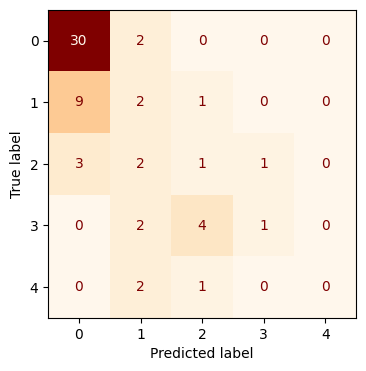

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# True labels
y_true = alltest.iloc[:, -2] 

# Predicted labels
y_pred = alltest.iloc[:, -1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap="OrRd", ax=ax, colorbar=False)
plt.show()

In [25]:
from sklearn import metrics

# Balanced accuracy
metrics.balanced_accuracy_score(y_true, y_pred)

0.2779761904761905

In [26]:
# Precision
metrics.precision_score(y_true, y_pred,
                        average=None)

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([0.71428571, 0.2       , 0.14285714, 0.5       , 0.        ])

In [27]:
# Recall
metrics.recall_score(y_true, y_pred,
                     average=None)

array([0.9375    , 0.16666667, 0.14285714, 0.14285714, 0.        ])

In [28]:
# F1-score
metrics.f1_score(y_true, y_pred,
                 average=None)

array([0.81081081, 0.18181818, 0.14285714, 0.22222222, 0.        ])

In [29]:
#F-beta score
beta_1 = metrics.fbeta_score(y_true, y_pred,
                    average=None,
                    beta=1)
beta_2 = metrics.fbeta_score(y_true, y_pred,
                    average=None,
                    beta=.1)
print("beta=1", beta_1)
print("beta=2", beta_2)

beta=1 [0.81081081 0.18181818 0.14285714 0.22222222 0.        ]
beta=2 [0.71597353 0.19960474 0.14285714 0.48792271 0.        ]


### Classification report

In [30]:
from sklearn.metrics import classification_report

# Display classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.94      0.81        32
           1       0.20      0.17      0.18        12
           2       0.14      0.14      0.14         7
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0.00         3

    accuracy                           0.56        61
   macro avg       0.31      0.28      0.27        61
weighted avg       0.49      0.56      0.50        61



c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo